In [1]:
import pandas as pd
import numpy as np
import hdbscan
import matplotlib as mpl
from helper import (get_repo_dir, mk_stacks, orjson_to_df, stacks_above_v, stack_over_v, viz_slider, viz_time)

In [2]:
%matplotlib ipympl
repo_dir = get_repo_dir()
#mpl.use('MacOSX')  # dont do this in VS Code

In [3]:
# load data
df_jc_pitch = pd.read_csv('./data/03.21-jc_pitch.csv', engine='pyarrow')
df_lab_lobs = pd.read_csv('./data/03.30-lab_lobs.csv', engine='pyarrow')
df_ao_pitch = pd.read_csv('./data/03.31-ao_pitch.csv', engine='pyarrow')

In [4]:
def do_hdbscan(df_in: pd.DataFrame, MIN_CLSTRS: int, NORM: bool = False) -> pd.DataFrame:
    from warnings import filterwarnings; filterwarnings('ignore', category=RuntimeWarning);

    df_out = pd.DataFrame()
    df_in = df_in.copy(deep=True)
    df_in['v'] = df_in['v'].abs()

    # add normalization here
    if NORM:
        df[['stack','x','y','z','v']] = df[['stack','x','y','z','v']].groupby('stack').apply(lambda x: (x - x.min()) / (x.max() - x.min())).fillna(0).drop('stack',axis=1).reset_index('stack')

    for stack,g in df_in.groupby('stack'):
        scan = hdbscan.HDBSCAN(min_cluster_size=MIN_CLSTRS, algorithm='best', alpha=1.0, metric='euclidean')
        g = g.copy(deep=True)
        #print(f"Length of g[{stack}] = {len(g)}")
        model = scan.fit(g[['x','y','z','v']])
        g = g.assign(outlier=model.outlier_scores_, clstr=model.labels_)
        df_out = pd.concat([df_out, g])

    df_out['outlier'] = df_out['outlier'].fillna(0)
    
    return df_out

In [5]:
df = mk_stacks(df_jc_pitch, 10, 'frame', ['stack','frame','ts'])
df = stack_over_v(df, 17)

In [6]:
def get_ball(df, MPH, OUT_SCORE, MIN_CLSTR):
    df = do_hdbscan(df, MIN_CLSTR)
    x = df.loc[(df['v'].abs() >= MPH) & (df['outlier'] >= OUT_SCORE)]
    return x.loc[x.loc[x['v'].abs() >= MPH][['frame','stack']].drop_duplicates()['frame'].drop_duplicates().index]

In [7]:
from os.path import isfile

In [8]:
df = orjson_to_df('/Users/alex/Documents/neu/linuxmnt/_pymmw/bball_data3b/data/2023.03.21_jc/log2.json')
df = df.loc[(df['v'] >= 0) & (df['frame'] <= 1500)]
df = mk_stacks(df, 20)

In [9]:
x = get_ball(df, 17, 0.75, 3)
x.assign(t=pd.to_datetime(x['ts'], unit='ms'))

,ts,frame,x,y,z,v,stack,outlier,clstr,t
10332,1679416602580,312,0.453262,1.546544,0.0,25.750093,312,0.797520,-1,2023-03-21 16:36:42.580
10420,1679416602613,313,0.389164,2.460058,0.0,22.462847,317,0.756621,-1,2023-03-21 16:36:42.613
14259,1679416605646,404,0.412056,1.405949,0.0,25.750093,404,0.810853,-1,2023-03-21 16:36:45.646
17934,1679416608513,490,0.384586,1.715526,0.0,24.654345,490,0.781083,-1,2023-03-21 16:36:48.513
18018,1679416608546,491,0.389164,2.460058,0.0,24.106470,491,0.766624,-1,2023-03-21 16:36:48.546
18081,1679416608579,492,0.526516,3.328315,0.0,24.654345,492,0.777572,-1,2023-03-21 16:36:48.579
23142,1679416611980,594,0.453262,1.546544,0.0,25.202219,594,0.791809,-1,2023-03-21 16:36:51.980
23247,1679416612013,595,0.439526,2.302567,0.0,22.462847,595,0.753428,-1,2023-03-21 16:36:52.013
28328,1679416615280,693,0.389164,2.460058,0.0,25.202219,713,0.835976,-1,2023-03-21 16:36:55.280
32759,1679416618514,790,0.608927,2.716250,0.0,24.654345,810,0.826977,-1,2023-03-21 16:36:58.514


## -- BELOW THIS IS SCRAP, NOTES, & EFFICIENCY BENCHMARKS FOR STRESS TESTING PRIOR TO REAL-TIME IMPLEMENTATION --

In [ ]:
%timeit df[['stack','x','y','z','v']] = df[['stack','x','y','z','v']].groupby('stack').apply(lambda x: (x - x.min()) / (x.max() - x.min())).fillna(0).drop('stack',axis=1).reset_index('stack')

435 ms ± 8.88 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
%timeit df['x'].sub(df['x'].min()).div(df['x'].max() - df['x'].min()).mul(1 - 0).add(0)

415 µs ± 7.53 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [ ]:
%timeit df[['x']].apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=0)

566 µs ± 9.04 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [ ]:
%%timeit
df['x'].sub(df['x'].min()).div(df['x'].max() - df['x'].min()).mul(1 - 0).add(0)
df['y'].sub(df['y'].min()).div(df['y'].max() - df['y'].min()).mul(1 - 0).add(0)
df['z'].sub(df['z'].min()).div(df['z'].max() - df['z'].min()).mul(1 - 0).add(0)
df['v'].sub(df['v'].min()).div(df['v'].max() - df['v'].min()).mul(1 - 0).add(0)


1.7 ms ± 46.5 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [ ]:
df[['stack','x','y','z','v']].groupby('stack').apply(lambda x: (x - x.min()) / (x.max() - x.min())).fillna(0).drop('stack',axis=1).reset_index('stack')


,stack,x,y,z,v
13771,312,0.590278,0.223512,0.0,0.187500
13782,312,0.347222,0.215917,0.0,0.250000
13793,312,0.550926,0.323522,0.0,0.250000
134738,312,0.329861,0.185166,0.0,0.250000
134749,312,0.828704,0.834415,0.0,0.250000
...,...,...,...,...,...
256179,3627,0.346337,0.079495,0.0,0.431193
256190,3627,0.133206,0.378476,0.0,0.431193
256135,3627,0.361560,0.039345,0.0,0.449541
256146,3627,0.350143,0.080209,0.0,0.449541


In [ ]:
%%timeit
df.apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=1)

7.56 s ± 45.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [24]:
df.apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=0).head()

,ts,frame,x,y,z,v,stack
13771,0.000000,0.0,0.429074,0.096417,0.0,0.472,0.0
13782,0.000000,0.0,0.379836,0.093141,0.0,0.504,0.0
13793,0.000000,0.0,0.421102,0.139558,0.0,0.504,0.0
134738,0.247625,0.0,0.376319,0.079875,0.0,0.504,0.0
134749,0.247625,0.0,0.477374,0.359944,0.0,0.504,0.0


In [25]:
df.apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=1).head()

,ts,frame,x,y,z,v,stack
13771,1.0,1.814555e-10,1.876502e-12,2.468310e-12,1.631145e-12,0.000000e+00,1.874100e-10
13782,1.0,1.801515e-10,0.000000e+00,1.135860e-12,3.271423e-13,9.132617e-16,1.861060e-10
13793,1.0,1.801506e-10,4.788954e-13,1.537981e-12,3.262290e-13,0.000000e+00,1.861050e-10
134738,1.0,1.801924e-10,0.000000e+00,1.061574e-12,3.680350e-13,4.180603e-14,1.861468e-10
134749,1.0,1.801506e-10,1.133180e-12,3.451536e-12,3.262290e-13,0.000000e+00,1.861050e-10


In [8]:
df['x'] = df['x'].sub(df['x'].min()).div(df['x'].max() - df['x'].min()).mul(1 - 0).add(0)
df['y'] = df['y'].sub(df['y'].min()).div(df['y'].max() - df['y'].min()).mul(1 - 0).add(0)
df['z'] = df['z'].sub(df['z'].min()).div(df['z'].max() - df['z'].min()).mul(1 - 0).add(0)
df['v'] = df['v'].sub(df['v'].min()).div(df['v'].max() - df['v'].min()).mul(1 - 0).add(0)


In [21]:
df.head()

,ts,frame,x,y,z,v,stack
13771,1679416411875,302,0.412056,1.405949,0.0,-2.739372,312
13782,1679416411875,302,-0.549408,1.358173,0.0,-0.547874,312
13793,1679416411875,302,0.256390,2.035036,0.0,-0.547874,312
134738,1679416602245,302,-0.618084,1.164742,0.0,-0.547874,312
134749,1679416602245,302,1.355206,5.248693,0.0,-0.547874,312


In [22]:
df.apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=0).head()

,ts,frame,x,y,z,v,stack
13771,0.000000,0.0,0.429074,0.096417,0.0,0.472,0.0
13782,0.000000,0.0,0.379836,0.093141,0.0,0.504,0.0
13793,0.000000,0.0,0.421102,0.139558,0.0,0.504,0.0
134738,0.247625,0.0,0.376319,0.079875,0.0,0.504,0.0
134749,0.247625,0.0,0.477374,0.359944,0.0,0.504,0.0


In [11]:
d = do_hdbscan(df, 4)
d

,ts,frame,x,y,z,v,stack,outlier,clstr
13771,1679416411875,302,0.412056,1.405949,0.0,2.739372,312,0.000000,4
13782,1679416411875,302,-0.549408,1.358173,0.0,0.547874,312,0.000000,7
13793,1679416411875,302,0.256390,2.035036,0.0,0.547874,312,0.000000,5
134738,1679416602245,302,-0.618084,1.164742,0.0,0.547874,312,0.000000,7
134749,1679416602245,302,1.355206,5.248693,0.0,0.547874,312,0.000000,0
...,...,...,...,...,...,...,...,...,...
256179,1679416718549,3627,-0.329645,1.124759,0.0,0.547874,3627,0.787615,0
256190,1679416718549,3627,-2.380768,5.354967,0.0,0.547874,3627,0.445514,1
256135,1679416718549,3627,-0.183136,0.556685,0.0,0.547874,3627,0.000000,0
256146,1679416718549,3627,-0.293018,1.134852,0.0,0.547874,3627,0.786148,0


In [39]:
x = d.loc[(d['v'].abs() >= 17) & (d['outlier'] >= 0.95)]
#x.loc[x['v'].abs() >= 17][['frame','stack']].drop_duplicates().groupby('stack').apply(lambda i: i.iloc[0])
#idx = x.loc[x['v'].abs() >= 17][['frame','stack']].drop_duplicates()['frame'].drop_duplicates().index
#x.loc[idx]
x.loc[x.loc[x['v'].abs() >= 17][['frame','stack']].drop_duplicates()['frame'].drop_duplicates().index]

,ts,frame,x,y,z,v,stack,outlier,clstr
228536,1679416692015,2878,-0.283861,0.072680,0.0,21.367100,2878,0.950444,-1
124696,1679416505477,3082,-0.283861,0.072680,0.0,33.968208,3082,0.990880,-1
248787,1679416711749,3424,-0.283861,0.072680,0.0,35.063957,3424,0.989415,-1
254189,1679416717716,3602,0.064098,0.285921,0.0,17.531979,3603,0.973249,-1


In [47]:
df = orjson_to_df(['/Users/alex/Documents/neu/linuxmnt/_pymmw/bball_data3b/data/2023.03.21_jc/log2.json'])
df = df.loc[(df['v'] >= 0) & (df['frame'] <= 1500)]
df = mk_stacks(df, 20)

In [59]:
def get_ball(df, MPH, OUT_SCORE, MIN_CLSTR):
    df = do_hdbscan(df, MIN_CLSTR)
    x = df.loc[(df['v'].abs() >= MPH) & (df['outlier'] >= OUT_SCORE)]
    return x.loc[x.loc[x['v'].abs() >= MPH][['frame','stack']].drop_duplicates()['frame'].drop_duplicates().index]

In [62]:
x = get_ball(df, 17, 0.75, 3)
x.assign(t=pd.to_datetime(x['ts'], unit='ms'))

,ts,frame,x,y,z,v,stack,outlier,clstr,t
10332,1679416602580,312,0.453262,1.546544,0.0,25.750093,312,0.797520,-1,2023-03-21 16:36:42.580
10420,1679416602613,313,0.389164,2.460058,0.0,22.462847,317,0.756621,-1,2023-03-21 16:36:42.613
14259,1679416605646,404,0.412056,1.405949,0.0,25.750093,404,0.810853,-1,2023-03-21 16:36:45.646
17934,1679416608513,490,0.384586,1.715526,0.0,24.654345,490,0.781083,-1,2023-03-21 16:36:48.513
18018,1679416608546,491,0.389164,2.460058,0.0,24.106470,491,0.766624,-1,2023-03-21 16:36:48.546
18081,1679416608579,492,0.526516,3.328315,0.0,24.654345,492,0.777572,-1,2023-03-21 16:36:48.579
23142,1679416611980,594,0.453262,1.546544,0.0,25.202219,594,0.791809,-1,2023-03-21 16:36:51.980
23247,1679416612013,595,0.439526,2.302567,0.0,22.462847,595,0.753428,-1,2023-03-21 16:36:52.013
28328,1679416615280,693,0.389164,2.460058,0.0,25.202219,713,0.835976,-1,2023-03-21 16:36:55.280
32759,1679416618514,790,0.608927,2.716250,0.0,24.654345,810,0.826977,-1,2023-03-21 16:36:58.514


len(df)=61047    ANIM_COL=stack
COLOR1_COL:          v    COLOR1_TITLE:   Velocity (m/s)
COLOR2_COL:      frame    COLOR2_TITLE:          Frame #
Displaying columns 'v' and 'frame' on two subplots


/Users/alex/Documents/neu/linuxmnt/_pymmw/bball_data3b/helper.py:580: UserWarning: Attempting to set identical low and high zlims makes transformation singular; automatically expanding.
  ax.set_zlim(*max_bounds['z'])
/Users/alex/Documents/neu/linuxmnt/_pymmw/bball_data3b/helper.py:580: UserWarning: Attempting to set identical low and high zlims makes transformation singular; automatically expanding.
  ax.set_zlim(*max_bounds['z'])


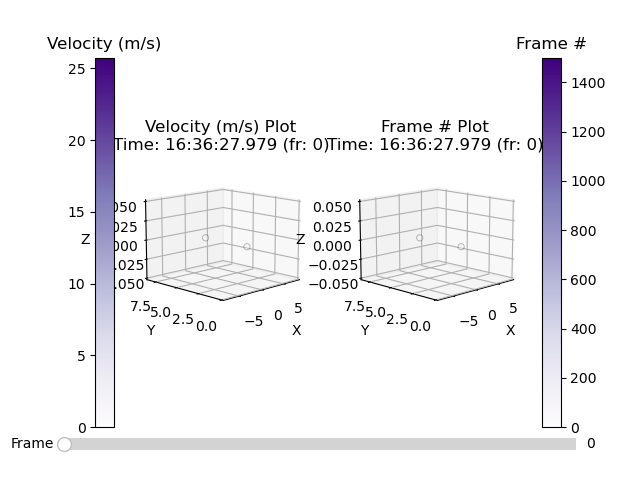

In [59]:
anim = viz_slider(df, COLOR1_COL='v', COLOR1_TITLE='Velocity (m/s)', COLOR2_COL='frame', COLOR2_TITLE='Frame #', OPACITY_COL='frame')

In [7]:
mpl.use('MacOSX')

In [8]:
anim = viz_slider(dd, COLOR1_COL='v', COLOR1_TITLE='Velocity (m/s)', COLOR2_COL='frame', COLOR2_TITLE='Frame #', OPACITY_COL='frame')

len(df)=65248    ANIM_COL=stack
COLOR1_COL:          v    COLOR1_TITLE:   Velocity (m/s)
COLOR2_COL:      frame    COLOR2_TITLE:          Frame #
Displaying columns 'v' and 'frame' on two subplots


In [37]:
dd = stack_v(dd, 25).abs().round(2)[30:80]

In [15]:
stacks_above_v(dd, 35)[:50]

/Users/alex/Documents/neu/linuxmnt/_pymmw/bball_data3b/helper.py:53: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  N_f_stacks = f_stacks.groupby('frame').apply(lambda x: x.iloc[:N_STACKS]).reset_index(drop=True)['stack'].unique()


,ts,frame,x,y,z,v,stack
100858,1679416483509,2432,-8.790529e-01,7.752517e-01,0.0,5.478743e-01,2442
100869,1679416483509,2432,6.867601e-02,2.196559e+00,0.0,-5.478743e-01,2442
100879,1679416483543,2433,1.401298e-45,3.858821e-34,0.0,1.745951e-39,2442
100880,1679416483543,2433,1.401298e-45,3.858821e-34,0.0,1.745951e-39,2443
100889,1679416483576,2434,2.499806e+00,5.622715e+00,0.0,-5.478743e-01,2442
100890,1679416483576,2434,2.499806e+00,5.622715e+00,0.0,-5.478743e-01,2443
100891,1679416483576,2434,2.499806e+00,5.622715e+00,0.0,-5.478743e-01,2444
100900,1679416483576,2434,2.618845e+00,5.890464e+00,0.0,-5.478743e-01,2442
100901,1679416483576,2434,2.618845e+00,5.890464e+00,0.0,-5.478743e-01,2443
100902,1679416483576,2434,2.618845e+00,5.890464e+00,0.0,-5.478743e-01,2444


In [7]:
d = do_hdbscan(dd, 4)
d

,ts,frame,x,y,z,v,stack,outlier,clstr
13760,1679416411875,302,-0.201450,1.598957,0.0,0.547874,312,0.000000,7
13771,1679416411875,302,0.412056,1.405949,0.0,2.739372,312,0.000000,4
13782,1679416411875,302,-0.549408,1.358173,0.0,0.547874,312,0.000000,7
13793,1679416411875,302,0.256390,2.035036,0.0,0.547874,312,0.000000,5
13803,1679416411908,303,-0.595192,1.338742,0.0,0.547874,312,0.000000,7
...,...,...,...,...,...,...,...,...,...
256146,1679416718549,3627,-0.293018,1.134852,0.0,0.547874,3627,0.786148,0
256157,1679416718549,3627,-2.815716,5.306046,0.0,0.547874,3627,0.625171,1
256168,1679416718549,3627,-0.183136,0.556685,0.0,0.547874,3627,0.000000,0
256179,1679416718549,3627,-0.329645,1.124759,0.0,0.547874,3627,0.787615,0


In [41]:
mpl.use('MacOSX')

len(df)=65248    ANIM_COL=stack
COLOR1_COL:          v    COLOR1_TITLE:   Velocity (m/s)
COLOR2_COL:      clstr    COLOR2_TITLE:         Cluster!
Displaying columns 'v' and 'clstr' on two subplots


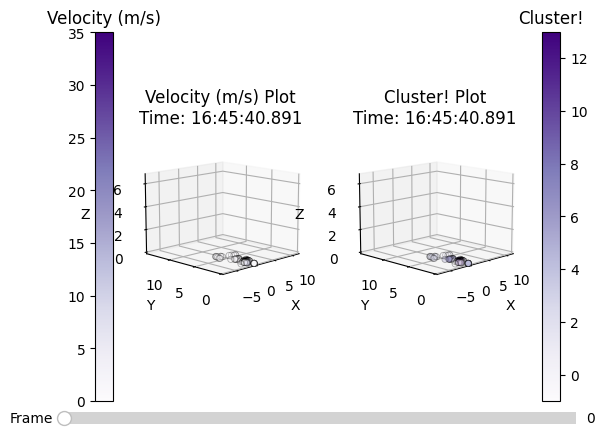

In [8]:
anim = viz_slider(d, COLOR1_COL='v', COLOR1_TITLE='Velocity (m/s)', COLOR2_COL='clstr', COLOR2_TITLE='Cluster!')
anim

In [9]:
mpl.use('MacOSX')

In [10]:
anim = viz_slider(d, COLOR1_COL='v', COLOR1_TITLE='Velocity (m/s)', COLOR2_COL='clstr', COLOR2_TITLE='Cluster!')
anim

len(df)=65248    ANIM_COL=stack
COLOR1_COL:          v    COLOR1_TITLE:   Velocity (m/s)
COLOR2_COL:      clstr    COLOR2_TITLE:         Cluster!
Displaying columns 'v' and 'clstr' on two subplots


In [6]:
#viz_slider(df)

In [7]:
#pd.to_datetime(1679417167758, unit='ms')
pd.to_datetime(1679417157990, unit='ms')

Timestamp('2023-03-21 16:45:57.990000')

In [12]:
df

,ts,frame,x,y,z,v,stack
0,1679416401675,0,-0.503624,0.531962,0.0,0.547874,0
1,1679416401675,0,-0.503624,0.531962,0.0,0.547874,1
2,1679416401675,0,-0.503624,0.531962,0.0,0.547874,2
3,1679416401675,0,-0.503624,0.531962,0.0,0.547874,3
4,1679416401675,0,-0.503624,0.531962,0.0,0.547874,4
...,...,...,...,...,...,...,...
366548,1679417180658,1330,0.343380,3.646589,0.0,-0.547874,1336
366549,1679417180658,1330,0.343380,3.646589,0.0,-0.547874,1337
366550,1679417180658,1330,0.343380,3.646589,0.0,-0.547874,1338
366551,1679417180658,1330,0.343380,3.646589,0.0,-0.547874,1339


In [10]:
#df_jc_pitch.loc[df_jc_pitch['v'] >= 20]
df_ao_pitch.loc[df_ao_pitch['v'] >= 20].value_counts()

ts             frame  x          y         z           v        
1680266327249  855    -1.081538  1.792841  -0.969300   20.138342    1
1680267202058  3801   -6.393090  2.015364  -8.426250   20.287514    1
1680267194795  3716   -4.758767  5.215329  -10.544748  20.138342    1
1680267194727  3714   -4.758767  4.419314  -10.902341  20.138342    1
1680267194695  3713   -2.499554  5.402652  -8.032927   20.138342    1
                                                                   ..
1680266854112  12645  -1.730461  2.392699  -3.546079   20.436687    1
                      -1.874666  2.745262  -3.200522   20.138342    1
1680266854045  12643  -1.586256  2.963956  -3.161160   20.138342    1
1680266853046  12613  -1.730461  1.403300  -2.648439   20.287514    1
1680267892168  228    -0.036051  0.452375  -1.060634   20.138342    1
Length: 1343, dtype: int64

In [1]:
df_jc_pitch.loc[df_jc_pitch['v'] >= 20,'v'].value_counts()

NameError: name 'df_jc_pitch' is not defined

In [ ]:
df_ao_pitch.loc[df_ao_pitch['v'] >= 20,'v'].value_counts()